# inspect llc4320 searching for anomalous jumps detected by Anna

---

In [7]:
import os

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xgcm

import mitequinox.utils as ut

In [2]:
from dask.distributed import Client

if True:
    from dask.distributed import LocalCluster
    cluster = LocalCluster()
elif False:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=1, cores=4) # 4 threads per worker
    # it seems using more threads leads to a much larger memory footprint
    # production runs use only one thread
    w = cluster.scale(jobs=3)
elif False:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=4)
#
client = Client(cluster)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/

---

# load data


In [14]:
face = 1

v = ["Eta", "SSU", "SSV"]
ds = ut.load_data(v).sel(face=face)
grd = ut.load_grd(V=["XC", "YC", "dxC", "dyC"]).sel(face=face)

ds = ds.assign_coords(**grd.variables)
grid = xgcm.Grid(ds, periodic=['X', 'Y'])

In [16]:
t = ds.time[100]
ds_snap = ds.sel(time=t)

In [24]:
def add_coriolis(ds):
    g = 9.81
    ds["fug"] = grid.diff(g * ds["Eta"], "Y") / ds.dyC 
    ds["fvg"] = grid.diff(g * ds["Eta"], "X") / ds.dxC 
    return ds

ds_snap = add_coriolis(ds_snap)


In [25]:
i_slice = slice(2700, 3100)
j_slice = slice(1550, 1750)
_ds = ds_snap.isel(i=i_slice, j=j_slice, i_g=i_slice, j_g=j_slice)

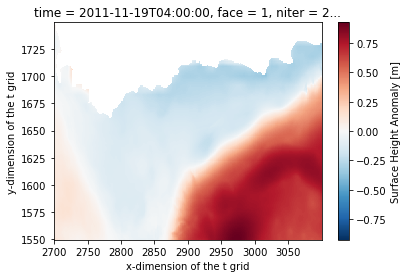

In [26]:
_ds.Eta.plot()

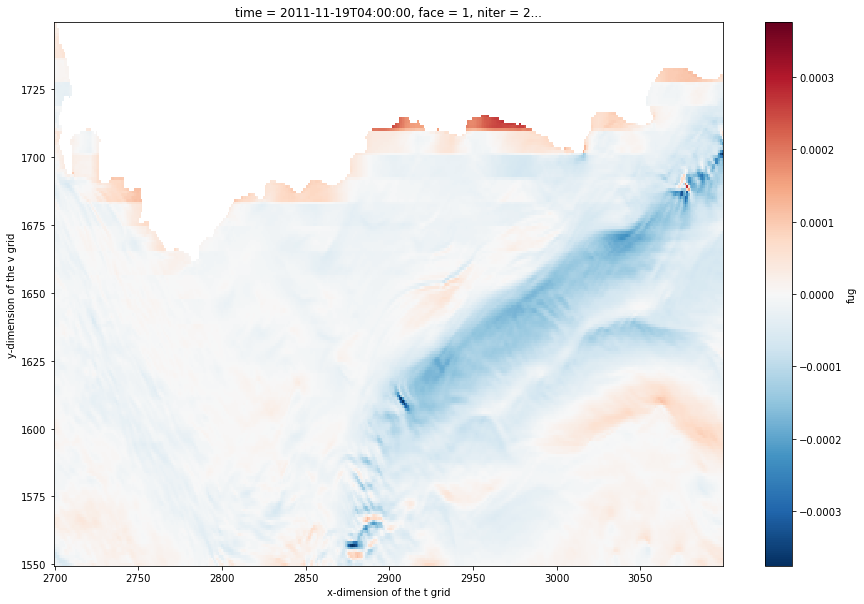

In [33]:
_ds.fug.plot(figsize=(15,10))

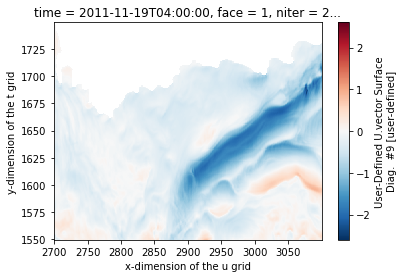

In [28]:
_ds.SSU.plot()

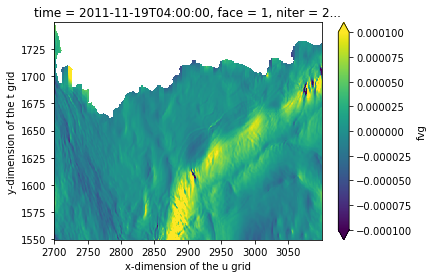

In [36]:
_ds.fvg.plot(vmin=-1e-4, vmax=1e-4) 

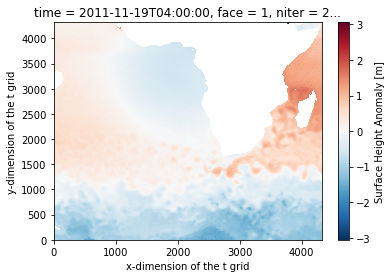

In [13]:
ds.Eta.plot()

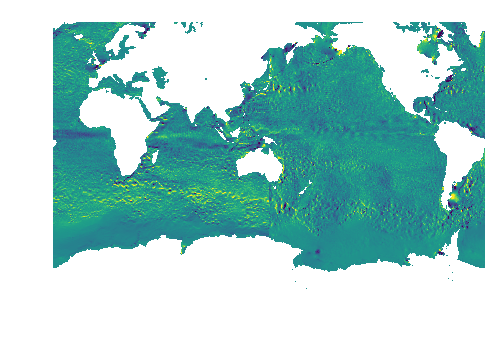

In [8]:
quick_llc_plot(ds.SSU, vmin=-1., vmax=1., 
               add_colorbar=False, axis_off=True)

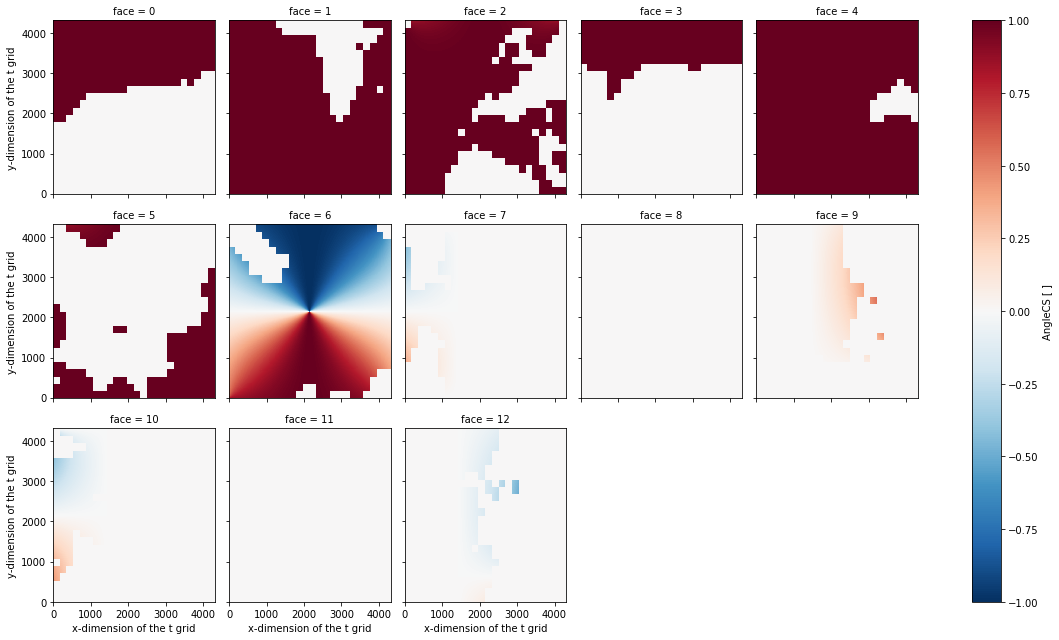

In [9]:
ds.CS.plot(col='face', col_wrap=5)

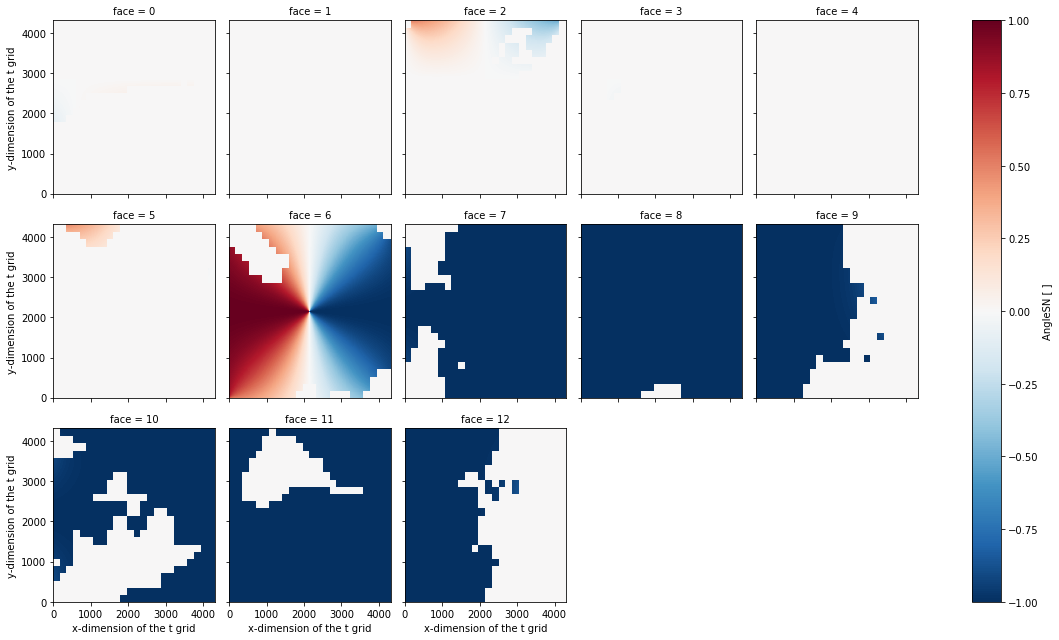

In [10]:
ds.SN.plot(col='face', col_wrap=5)

---

## compute and plot rotated currents


In [11]:
# should do proper grid interpolation instead of renaming
U =  ds.SSU.rename({'i_g': 'i'})*ds.CS - ds.SSV.rename({'j_g': 'j'})*ds.SN
V =  ds.SSU.rename({'i_g': 'i'})*ds.SN + ds.SSV.rename({'j_g': 'j'})*ds.CS
U.persist()
V.persist()

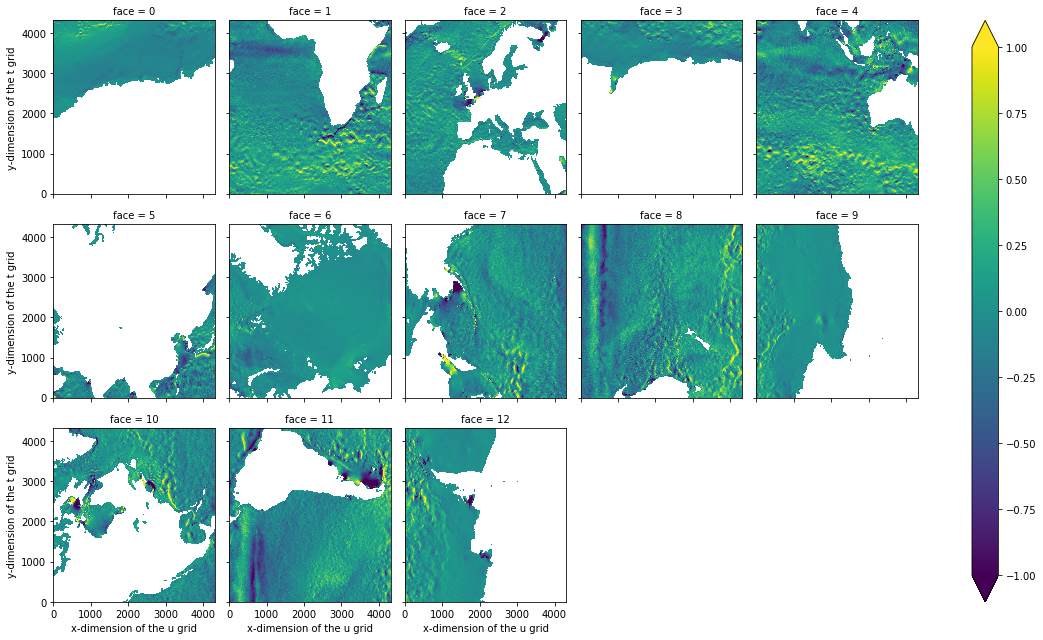

In [12]:
U.plot(col='face', col_wrap=5, vmin=-1., vmax=1.)

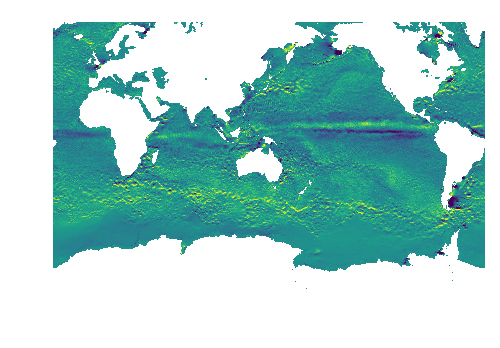

In [13]:
quick_llc_plot(U, vmin=-1., vmax=1., 
               add_colorbar=False, axis_off=True)

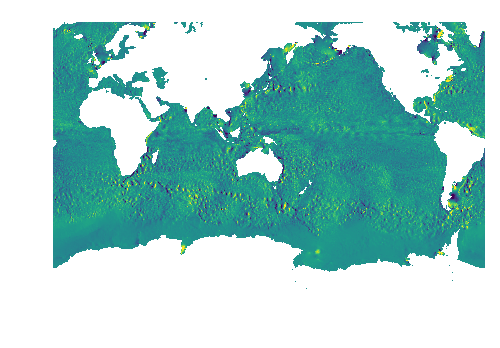

In [14]:
quick_llc_plot(V, vmin=-1., vmax=1., 
               add_colorbar=False, axis_off=True)

---

In [27]:
# add workers
w = cluster.scale_up(10)

In [15]:
# kill scheduler, workers
cluster.scheduler.close()
#cluster.stop_workers(cluster.jobs)

<Future pending cb=[_make_coroutine_wrapper.<locals>.wrapper.<locals>.<lambda>() at /home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py:347]>

In [ ]:
# restart workers
client.restart()

In [ ]:
client